<a href="https://colab.research.google.com/github/tshnoudeh-droid/hyperloop-propulsion-sim/blob/main/Replicate2_Hyperloop_Simulation_Tawfic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: imports and helper utilities
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from math import isclose

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

def to_kmh(m_s):
    return m_s * 3.6

def energy_from_power(power_w, t_s):
    # power_w: array of instantaneous power values (W)
    # t_s: array of time samples (s)
    # returns cumulative energy in kWh
    dt = np.diff(t_s, prepend=t_s[0])
    energy_j = np.sum(power_w * dt)   # Joules
    energy_kwh = energy_j / (3600 * 1000)
    return energy_kwh


In [2]:
# Cell 2: parameters
m = 2000.0           # mass of pod (kg) - reasonable small pod
A = 1.5              # frontal area (m^2)
Cd = 0.2             # drag coefficient (streamlined pod)
rho0 = 1.225         # air density at sea level (kg/m^3)
pressure_fraction = 0.01  # fraction of atmosphere in tube (1% atm)
rho = rho0 * pressure_fraction

# Simulation time
t_final = 400.0      # seconds
dt = 0.1
t = np.arange(0.0, t_final + dt, dt)

# Thrust profile examples (in Newtons)
def thrust_constant(t, F=20000.0):
    return F

def thrust_ramp(t, t_ramp=30.0, F_max=20000.0):
    return F_max * min(1.0, t / t_ramp)

def thrust_pulse(t, pulses=[(0,50,20000),(100,130,15000)], baseline=0.0):
    # pulses: list of tuples (t_start, t_end, F_value)
    F = baseline
    for (ts, te, fv) in pulses:
        if ts <= t <= te:
            F = fv
            break
    return F


In [3]:
# Cell 3: ODE dynamics function
def dynamics(state, time, m, A, Cd, rho, thrust_fn):
    v, x = state  # v (m/s), x (m)
    F_prop = thrust_fn(time)
    F_drag = 0.5 * rho * Cd * A * v**2
    F_net = F_prop - F_drag
    a = F_net / m
    # Prevent negative speeds if drag > thrust and v ~ 0 -> clamp small negative a
    return [a, v]


In [4]:
# Cell 4: run simulation (wrapper)
def run_sim(thrust_fn, m=m, A=A, Cd=Cd, rho=rho, t=t):
    initial = [0.0, 0.0]  # start at rest (v=0 m/s, x=0 m)
    sol = odeint(dynamics, initial, t, args=(m, A, Cd, rho, thrust_fn))
    v = sol[:,0]   # m/s
    x = sol[:,1]   # m
    # compute instantaneous power (P = F_prop * v)
    F_prop_array = np.array([thrust_fn(tt) for tt in t])
    power_w = F_prop_array * v
    energy_kwh = energy_from_power(power_w, t)
    return {'t': t, 'v': v, 'x': x, 'F_prop': F_prop_array, 'power_w': power_w, 'energy_kwh': energy_kwh}


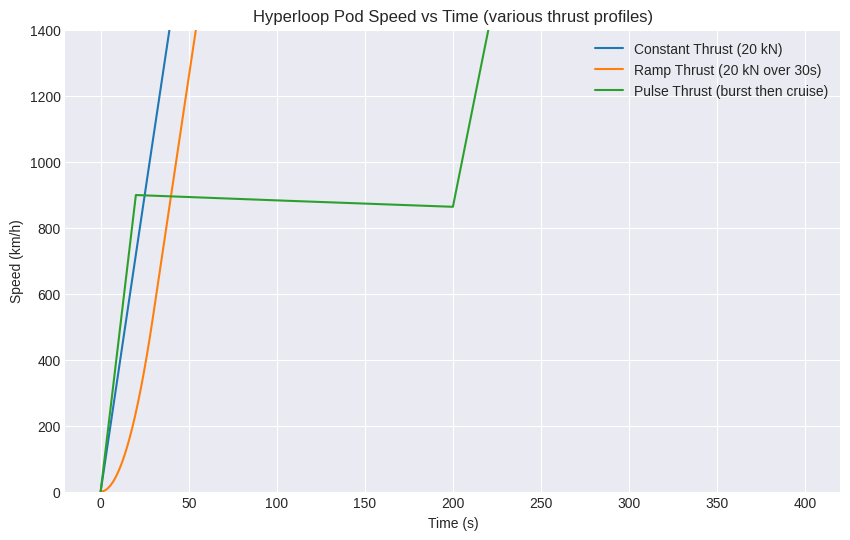

Constant Thrust (20 kN)  →  Energy used (kWh): 3653.553   Max speed (km/h): 9945.8
Ramp Thrust (20 kN over 30s)  →  Energy used (kWh): 3425.197   Max speed (km/h): 9778.2
Pulse Thrust (burst then cruise)  →  Energy used (kWh): 132.698   Max speed (km/h): 2437.8


In [5]:
# Cell 5: run and plot a few scenarios
scenarios = {
    'Constant Thrust (20 kN)': lambda tt: thrust_constant(tt, F=20000.0),
    'Ramp Thrust (20 kN over 30s)': lambda tt: thrust_ramp(tt, t_ramp=30.0, F_max=20000.0),
    'Pulse Thrust (burst then cruise)': lambda tt: thrust_pulse(tt, pulses=[(0,20,25000),(200,260,15000)], baseline=0.0)
}

results = {}
plt.figure(figsize=(10,6))
for name, fn in scenarios.items():
    res = run_sim(fn)
    results[name] = res
    plt.plot(res['t'], to_kmh(res['v']), label=name)

plt.xlabel('Time (s)')
plt.ylabel('Speed (km/h)')
plt.title('Hyperloop Pod Speed vs Time (various thrust profiles)')
plt.legend()
plt.ylim(0, 1400)
plt.show()

# Show energy consumed for each scenario
for name,res in results.items():
    print(f"{name}  →  Energy used (kWh): {res['energy_kwh']:.3f}   Max speed (km/h): {to_kmh(np.max(res['v'])):.1f}")


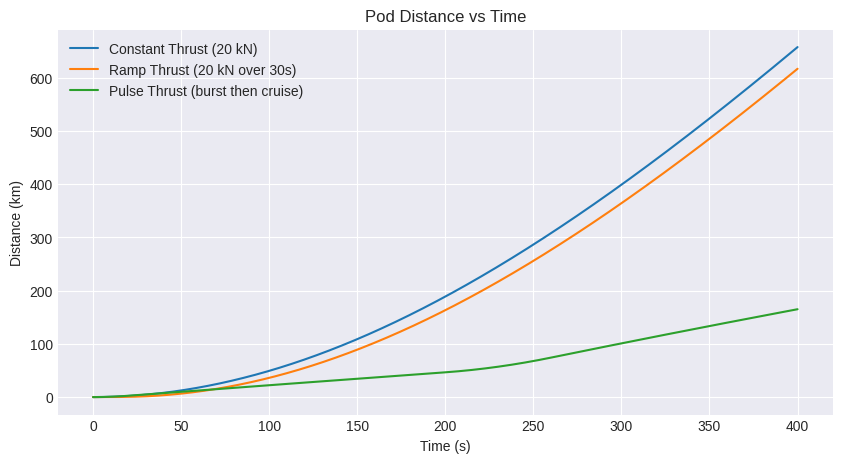

Constant Thrust (20 kN): reached 100.0 km in 143.6 s (0.04 hours).
Ramp Thrust (20 kN over 30s): reached 100.0 km in 158.4 s (0.04 hours).
Pulse Thrust (burst then cruise): reached 100.0 km in 298.7 s (0.08 hours).


In [6]:
# Cell 6: Distance vs time and time-to-distance helper
plt.figure(figsize=(10,5))
for name,res in results.items():
    plt.plot(res['t'], res['x']/1000.0, label=name)  # km
plt.xlabel('Time (s)')
plt.ylabel('Distance (km)')
plt.title('Pod Distance vs Time')
plt.legend()
plt.show()

# helper: time to reach a given distance (km)
def time_to_distance(res, km):
    idx = np.where(res['x'] >= km*1000.0)[0]
    if len(idx)==0:
        return None
    return res['t'][idx[0]]

target_km = 100.0
for name,res in results.items():
    t_reach = time_to_distance(res, target_km)
    if t_reach is None:
        print(f"{name}: did not reach {target_km} km in simulation time.")
    else:
        print(f"{name}: reached {target_km} km in {t_reach:.1f} s ({t_reach/3600:.2f} hours).")


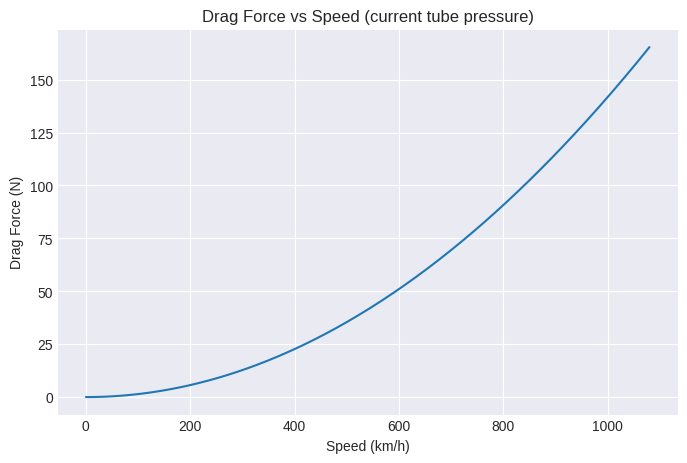

In [7]:
# Cell 7: Drag force vs speed for current rho, Cd, A
v_test = np.linspace(0, 300, 300)  # m/s
F_drag_test = 0.5 * rho * Cd * A * v_test**2

plt.figure(figsize=(8,5))
plt.plot(v_test*3.6, F_drag_test)
plt.xlabel('Speed (km/h)')
plt.ylabel('Drag Force (N)')
plt.title('Drag Force vs Speed (current tube pressure)')
plt.grid(True)
plt.show()


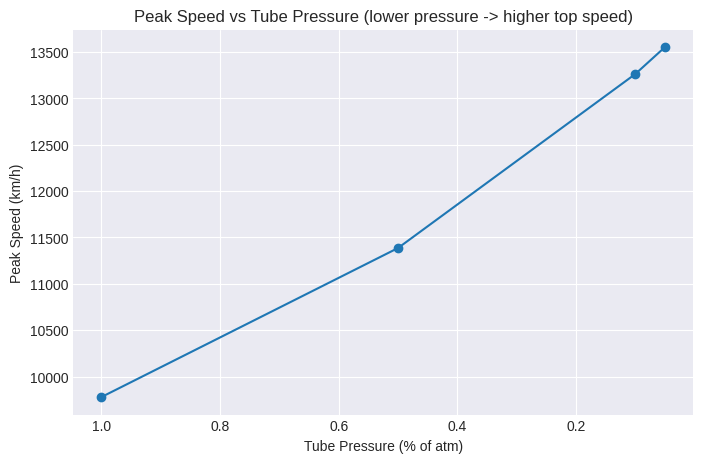

Pressure 0.01 (frac): Peak speed 9778.2 km/h, Energy 3425.197 kWh
Pressure 0.005 (frac): Peak speed 11385.9 km/h, Energy 3721.420 kWh
Pressure 0.001 (frac): Peak speed 13263.3 km/h, Energy 4028.188 kWh
Pressure 0.0005 (frac): Peak speed 13553.8 km/h, Energy 4072.510 kWh


In [8]:
# Cell 8: sweep pressure_fraction values and show peak speed
pressure_values = [0.01, 0.005, 0.001, 0.0005]  # 1%, 0.5%, 0.1%, 0.05% atm
peak_speeds = []
energy_use = []

for pf in pressure_values:
    rho_local = rho0 * pf
    def thrust_fn(tt): return thrust_ramp(tt, t_ramp=30.0, F_max=20000.0)
    res = run_sim(thrust_fn, rho=rho_local)
    peak_speeds.append(to_kmh(np.max(res['v'])))
    energy_use.append(res['energy_kwh'])

plt.figure(figsize=(8,5))
plt.plot([p*100 for p in pressure_values], peak_speeds, marker='o')
plt.xlabel('Tube Pressure (% of atm)')
plt.ylabel('Peak Speed (km/h)')
plt.title('Peak Speed vs Tube Pressure (lower pressure -> higher top speed)')
plt.gca().invert_xaxis()  # show vacuum left-to-right
plt.show()

for pf,spd,eng in zip(pressure_values, peak_speeds, energy_use):
    print(f"Pressure {pf} (frac): Peak speed {spd:.1f} km/h, Energy {eng:.3f} kWh")


In [9]:
# Cell 9: interactive demo
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    def interactive_run(m_val=2000, Cd_val=0.2, pressure_frac=0.01, Fmax=20000):
        rho_local = rho0 * pressure_frac
        def thrust_fn(tt): return thrust_ramp(tt, t_ramp=30.0, F_max=Fmax)
        res = run_sim(thrust_fn, m=m_val, Cd=Cd_val, rho=rho_local)
        plt.figure(figsize=(9,4))
        plt.plot(res['t'], to_kmh(res['v']))
        plt.xlabel('Time (s)')
        plt.ylabel('Speed (km/h)')
        plt.title('Interactive: Speed vs Time')
        plt.ylim(0, 1400)
        plt.show()
    interact(interactive_run,
             m_val=IntSlider(min=500,max=4000,step=100,value=2000),
             Cd_val=FloatSlider(min=0.08,max=0.35,step=0.01,value=0.2),
             pressure_frac=FloatSlider(min=0.0001,max=0.02,step=0.0005,value=0.01),
             Fmax=IntSlider(min=1000,max=50000,step=500,value=20000))
except Exception as e:
    print("Interactive widgets not available in this Colab environment. You can still change parameters by editing cells directly.")
    print(e)


interactive(children=(IntSlider(value=2000, description='m_val', max=4000, min=500, step=100), FloatSlider(val…

In [10]:
# Enables widget backend inside Google Colab
%pip install ipywidgets==8.1.2
from google.colab import output
output.enable_custom_widget_manager()